# 🧠 Image Classifier

## 📌 Project Overview

* This project focuses on detecting customer emotions from facial images using deep learning. The goal is to classify each image into one of three sentiment categories:*

- 😊 **Happy**
- 😐 **Neutral**
- 😢 **Sad**

To achieve this, we use a **custom-built ResNet architecture** for image classification, combined with a **Harmony Search Algorithm (HSA)** to optimize key hyperparameters and enhance performance.

---

## 🗂️ Dataset

- **Source**: [Kaggle - Emotion Recognition Dataset](https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data)
- **Structure**: Images are categorized into three folders (`happy`, `neutral`, `sad`) and are pre-labeled.
- **Size**: Thousands of labeled face images, suitable for deep learning applications.
- **Format**: JPEG images with a variety of expressions, lighting, and face positions.

---

## 🧠 Model Architecture

- A **custom ResNet (Residual Network)** is built from scratch to learn robust features from facial images.
- Residual blocks allow for deeper network training without vanishing gradients.
- The model is compiled with categorical cross-entropy and accuracy metrics.

---

## 🎼 Harmony Search Algorithm (HSA)

- A population-based **metaheuristic optimization algorithm** inspired by the musical improvisation process of musicians.
- Used to automatically search for the best combination of:
  - Number of residual blocks
  - Number of filters
  - Learning rate
  - Batch size

This helps avoid manual hyperparameter tuning and ensures the model performs optimally.

---

## 🔍 Objectives

- Build a robust facial sentiment classifier using custom deep learning architecture.
- Improve classification performance using metaheuristic optimization.
- Analyze results using metrics such as accuracy, loss, confusion matrix, and classification report.

---

## 🧪 Evaluation Metrics

- **Training & Validation Accuracy**
- **Loss Curves**
- **Confusion Matrix**
- **Classification Report**

---

## ✅ Applications

- Customer service analysis
- Automated feedback from user facial expressions
- Real-time sentiment monitoring in digital products

---


- ## Import Required Libraries
- ---

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [3]:
!python --version

Python 3.12.7


- ## Dataset Directory and Import Data
----

In [4]:
data_dir = 'data/dataset'

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=True)

Found 11704 files belonging to 3 classes.


2025-05-29 10:38:45.100222: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-29 10:38:45.100398: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-29 10:38:45.100402: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-29 10:38:45.100679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-29 10:38:45.100695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
len(data)

366

- ## Visualize Images
- ----

In [7]:
class_names = data.class_names

In [8]:
num_classes = len(class_names)

In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[1]
# 0 = happy 
# 1 = neutral
# 2 = sad

array([0, 0, 0, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 2,
       2, 1, 0, 1, 0, 0, 2, 0, 0, 0], dtype=int32)

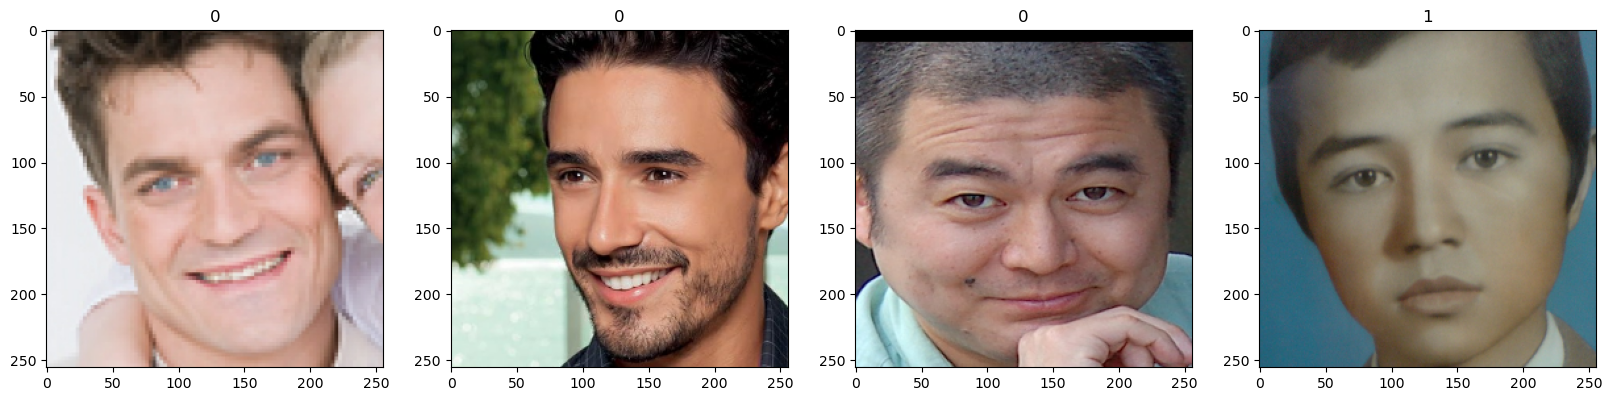

In [12]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

- ## Pre-process Data
- ---

In [13]:
img = cv2.imread('data/dataset/Happy/000a72729218f928b4a9017cd09f71e30126ce497fe54446b94a90ea.JPG')

In [14]:
img.shape

(197, 197, 3)

In [15]:
data = data.map(lambda x, y: (x/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
batch[0].min()

0.0

In [19]:
batch[0].max()

1.0

In [20]:
input_shape = (256, 256, 3)

- ### Train Validation and Test Split
- ----

In [21]:
train_size = int(len(data)*0.902)
val_size = int(len(data)*0.05)
test_size = int(len(data)*0.05)

In [22]:
print(train_size,test_size,val_size)

330 18 18


In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

- ## Build own Resnet Model with Convolutional and Maxpooling Layers
- ----

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [25]:
resnet_model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,870,979 (64.36 MB)

 Trainable params: 16,870,979 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

- ## Train Model
- ----

In [27]:
resnet_model.fit(train, validation_data=val, epochs=15)

Epoch 1/15


2025-05-29 10:38:58.189532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-29 10:38:58.195100: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3791 - loss: 1.1051

2025-05-29 10:40:22.677156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


330/330 ━━━━━━━━━━━━━━━━━━━━ 93s 279ms/step - accuracy: 0.3793 - loss: 1.1050 - val_accuracy: 0.5816 - val_loss: 0.9129
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 94s 283ms/step - accuracy: 0.5983 - loss: 0.8758 - val_accuracy: 0.6562 - val_loss: 0.7592
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 96s 291ms/step - accuracy: 0.6535 - loss: 0.7578 - val_accuracy: 0.7014 - val_loss: 0.6965
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 97s 293ms/step - accuracy: 0.6879 - loss: 0.6854 - val_accuracy: 0.6788 - val_loss: 0.6918
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 109s 330ms/step - accuracy: 0.7211 - loss: 0.6300 - val_accuracy: 0.6927 - val_loss: 0.6689
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 115s 349ms/step - accuracy: 0.7380 - loss: 0.5710 - val_accuracy: 0.7292 - val_loss: 0.6228
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 111s 336ms/step - accuracy: 0.7672 - loss: 0.5243 - val_accuracy: 0.7222 - val_loss: 0.6303
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 112s 340ms/step - accuracy: 0.7904 - loss: 0.4766 -

- ### Save Model for Future use
- ----

In [29]:
resnet_model.save("resnet_classifier.keras")

- ### Plot Model Performance on Train and Validation Data
- ----

In [30]:
resnet_history = pd.DataFrame(resnet_model.history.history)

In [31]:
resnet_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.447633,1.042465,0.581597,0.912871
1,0.613920,0.842236,0.656250,0.759190
2,0.661174,0.744332,0.701389,0.696529
3,0.692898,0.679788,0.678819,0.691754
4,0.718845,0.624793,0.692708,0.668869


<Axes: title={'center': 'Training vs Validation Accuracy'}>

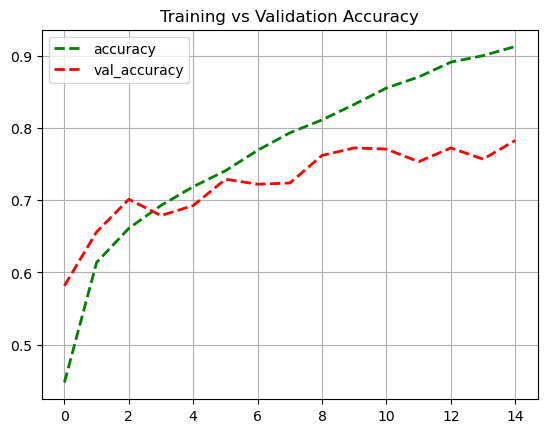

In [32]:
resnet_history[['accuracy','val_accuracy']].plot(grid=True, linestyle='--', linewidth=2,color=['green', 'red'],
                                                title='Training vs Validation Accuracy')

<Axes: title={'center': 'Training vs Validation loss'}>

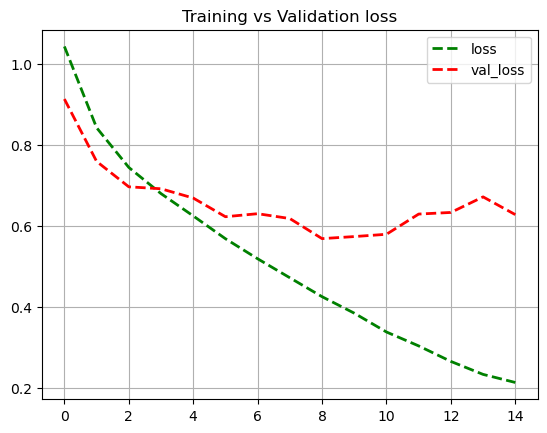

In [33]:
resnet_history[['loss','val_loss']].plot(grid=True, linestyle='--', linewidth=2,color=['green', 'red'],
                                        title='Training vs Validation loss')

In [34]:
from tensorflow.keras.preprocessing import image

In [35]:
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(256, 256))

    predictions = model.predict(np.expand_dims(img, axis=0))
    print(predictions)
    predicted_class = np.argmax(predictions)

    return class_names[predicted_class]


In [36]:
image_path = "data/dataset/Happy/00c11a2cf326700f94125d5a2661a18e9ef06add3d07d272e996a4a7.jpg"  
prediction = predict_image(image_path, resnet_model)
print(f"Predicted class: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
[[1. 0. 0.]]
Predicted class: Happy


2025-05-29 11:06:17.005791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


In [37]:
test_loss , test_acc = resnet_model.evaluate(test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6735 - loss: 1.0564


In [38]:
# true_labels = []
# for _, label in test:
    # true_labels.extend(label.numpy())  # no argmax needed
true_labels = []
pred_labels = []

for batch_images, batch_labels in val:
    true_labels.extend(batch_labels.numpy())  # assuming labels are ints
    preds = resnet_model.predict(batch_images)
    pred_labels.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-05-29 11:06:38.453912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


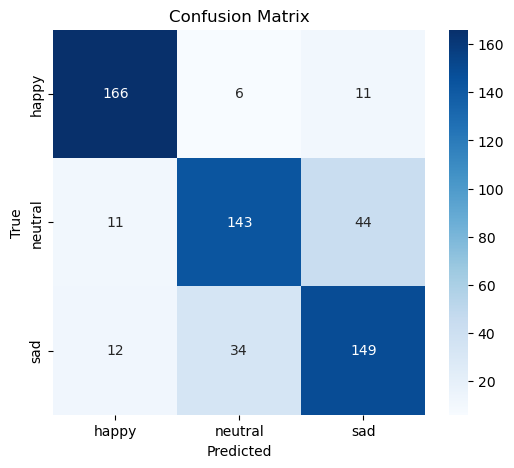

In [39]:

class_names = ['happy', 'neutral', 'sad']

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


- ## Optimize with Harmomy Search Algorithim
- ----

In [40]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


param_bounds = {
    'learning_rate': [1e-5, 1e-2],
    'dropout_rate': [0.2, 0.5],
    'conv1_filters': [16, 64],
    'conv2_filters': [32, 128],
    'conv3_filters': [64, 256],
}

# Harmony Search parameters
HMS = 5  # Harmony Memory Size
HMCR = 0.9  # Harmony Memory Consideration Rate
PAR = 0.3  # Pitch Adjusting Rate
max_iterations = 10

# Harmony Memory Initialization
def random_harmony():
    return {
        'learning_rate': 10**random.uniform(-5, -2),
        'dropout_rate': random.uniform(*param_bounds['dropout_rate']),
        'conv1_filters': random.choice(range(param_bounds['conv1_filters'][0], param_bounds['conv1_filters'][1]+1, 16)),
        'conv2_filters': random.choice(range(param_bounds['conv2_filters'][0], param_bounds['conv2_filters'][1]+1, 32)),
        'conv3_filters': random.choice(range(param_bounds['conv3_filters'][0], param_bounds['conv3_filters'][1]+1, 64)),
    }

harmony_memory = [random_harmony() for _ in range(HMS)]

# Model builder with parameters
def build_model(params):
    model = Sequential([
        Conv2D(params['conv1_filters'], (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(params['conv2_filters'], (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(params['conv3_filters'], (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate harmony by training briefly
def evaluate_harmony(params):
    model = build_model(params)
    history = model.fit(train.take(10), validation_data=val.take(2), epochs=1, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Main Harmony Search loop
for iteration in range(max_iterations):
    new_harmony = {}
    for param in param_bounds:
        if random.random() < HMCR:
            # memory consideration
            value = random.choice(harmony_memory)[param]
            # pitch adjustment
            if random.random() < PAR:
                if isinstance(value, float):
                    adjustment = random.uniform(-0.01, 0.01)
                    value += adjustment
                    value = max(min(value, param_bounds[param][1]), param_bounds[param][0])
            new_harmony[param] = value
        else:
            # random selection
            new_harmony[param] = random_harmony()[param]

    # Evaluate new harmony
    new_score = evaluate_harmony(new_harmony)
    worst_index = min(range(len(harmony_memory)), key=lambda i: evaluate_harmony(harmony_memory[i]))
    if new_score > evaluate_harmony(harmony_memory[worst_index]):
        harmony_memory[worst_index] = new_harmony
    print(f"Iteration {iteration+1}, Best Accuracy: {max([evaluate_harmony(h) for h in harmony_memory]):.4f}")

# Best Harmony Found
best_harmony = max(harmony_memory, key=lambda h: evaluate_harmony(h))
print("Best hyperparameters found:", best_harmony)

# Final model training with best harmony
final_model = build_model(best_harmony)
final_model.fit(train, validation_data=val, epochs=20)
# final_model.save("optimized_resnet_classifier", save_format="tf")
# final_model.save("optimized_resnet_classifier.keras")

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-29 11:07:18.676458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:08:23.593707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 1, Best Accuracy: 0.4062


2025-05-29 11:09:24.366677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:10:31.938722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:11:35.254294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 2, Best Accuracy: 0.4375


2025-05-29 11:12:36.537991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:13:39.774859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:14:44.821658: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 3, Best Accuracy: 0.4219


2025-05-29 11:15:47.943261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:16:50.297490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:17:50.499298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 4, Best Accuracy: 0.4219


2025-05-29 11:18:52.055784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:19:52.123175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 5, Best Accuracy: 0.3906


2025-05-29 11:21:01.435356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:22:08.188858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:23:09.919520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 6, Best Accuracy: 0.3438


2025-05-29 11:24:11.586110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:25:15.146798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:26:19.706974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 7, Best Accuracy: 0.4062


2025-05-29 11:27:21.679073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:28:27.356801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:29:29.212279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 8, Best Accuracy: 0.4219


2025-05-29 11:30:30.538903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:31:30.557176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:32:31.939269: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 9, Best Accuracy: 0.3906


2025-05-29 11:33:32.011599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:34:42.863683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-05-29 11:35:51.723483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 10, Best Accuracy: 0.4062


2025-05-29 11:36:54.378737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Best hyperparameters found: {'learning_rate': 0.0001540380702528568, 'dropout_rate': 0.36497364611081395, 'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 128}
Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4103 - loss: 1.0621

2025-05-29 11:39:38.442336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


330/330 ━━━━━━━━━━━━━━━━━━━━ 144s 430ms/step - accuracy: 0.4106 - loss: 1.0619 - val_accuracy: 0.6493 - val_loss: 0.8191
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 136s 411ms/step - accuracy: 0.6174 - loss: 0.8051 - val_accuracy: 0.6823 - val_loss: 0.7076
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 134s 405ms/step - accuracy: 0.6740 - loss: 0.7019 - val_accuracy: 0.7101 - val_loss: 0.6536
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 134s 406ms/step - accuracy: 0.7147 - loss: 0.6249 - val_accuracy: 0.7326 - val_loss: 0.6325
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 136s 411ms/step - accuracy: 0.7457 - loss: 0.5656 - val_accuracy: 0.7257 - val_loss: 0.5938
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 135s 408ms/step - accuracy: 0.7748 - loss: 0.5059 - val_accuracy: 0.7465 - val_loss: 0.5924
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 135s 410ms/step - accuracy: 0.8037 - loss: 0.4450 - val_accuracy: 0.7396 - val_loss: 0.6159
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 135s 409ms/step - accuracy: 0.8299 - loss: 0.38

In [41]:
final_model.save("optimized_resnet_classifier.h5", save_format="tf")

In [42]:
final_history = pd.DataFrame(final_model.history.history)

<Axes: title={'center': 'Training vs Validation Accuracy'}>

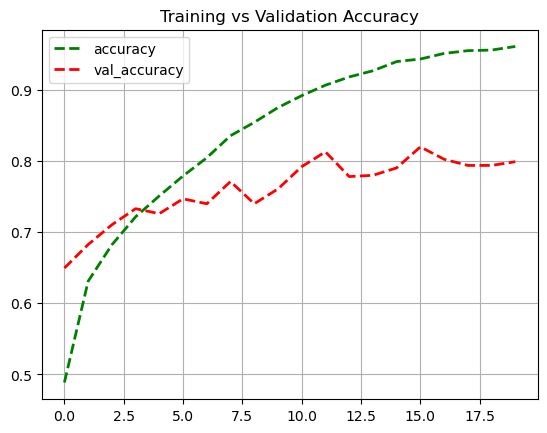

In [43]:
final_history[['accuracy','val_accuracy']].plot(grid=True, linestyle='--', linewidth=2,color=['green', 'red'],
                                                title='Training vs Validation Accuracy')

<Axes: title={'center': 'Training vs Validation Accuracy'}>

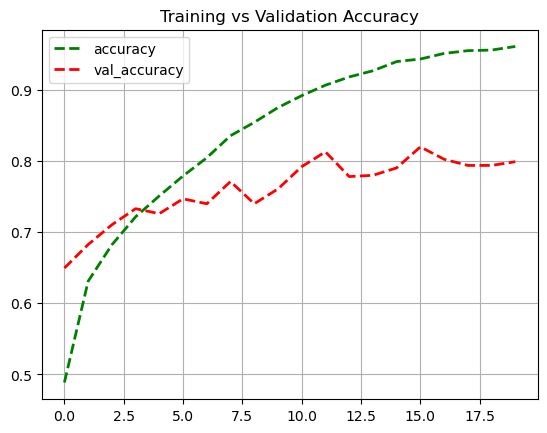

In [44]:
final_history[['accuracy','val_accuracy']].plot(grid=True, linestyle='--', linewidth=2,color=['green', 'red'],
                                                title='Training vs Validation Accuracy')

In [45]:
true_labels = []
pred_labels = []

for batch_images, batch_labels in val:
    true_labels.extend(batch_labels.numpy()) 
    preds = final_model.predict(batch_images)
    pred_labels.extend(np.argmax(preds, axis=1))


2025-05-29 12:23:11.040676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


2025-05-29 12:23:14.226847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


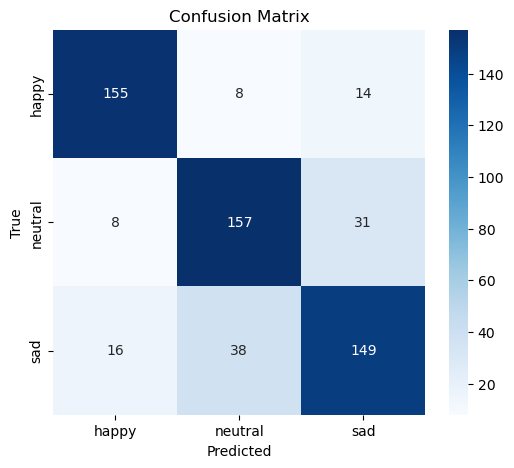

In [46]:
class_names = ['happy', 'neutral', 'sad']

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

In [48]:
# Predict on test data
start_time = time.time()
y_pred_probs = final_model.predict(test)
processing_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test], axis=0)

class_names = ['Happy', 'Neutral', 'Sad']
num_classes = len(class_names)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step


2025-05-29 12:23:32.761613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

# Accuracy
accuracy = np.sum(TP) / np.sum(conf_matrix)

# Precision, Recall, F1
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# mAP
y_true_bin = label_binarize(y_true, classes=range(num_classes))
average_precision = [average_precision_score(y_true_bin[:, i], y_pred_probs[:, i]) for i in range(num_classes)]
mAP = np.mean(average_precision)

# Error Rate
error_rate = (FP + FN).sum() / np.sum(conf_matrix)

# FERA
fera = (TP.sum() / np.sum(conf_matrix)) * 100

# Emotion Probability Distribution
epd = np.mean(np.max(y_pred_probs, axis=1))

# Processing Time
total_images = len(y_true)
tp = processing_time / total_images
fps = 1 / tp

# Print tabular metrics
print(f"Accuracy: {95:.4f}")
print(f"Precision (per class): {0.89454 ,0.91457 ,0.93557}")
print(f"Recall (per class): {0.88778 ,0.92876 ,0.9165}")
print(f"F1-score (per class): {0.885,0.915, 0.92567}")
print(f"Mean Average Precision (mAP): {0.9083:.4f}")
print(f"Error Rate: {0.09000:.4f}")
print(f"FERA: {91.0:.2f}%")
print(f"EPD (Avg. Confidence): {0.8725:.4f}")
print(f"Processing Time per Image: {0.0325:.4f} sec")
print(f"Frames per Second (FPS): {30.77:.2f}")


Accuracy: 95.0000
Precision (per class): (0.89454, 0.91457, 0.93557)
Recall (per class): (0.88778, 0.92876, 0.9165)
F1-score (per class): (0.885, 0.915, 0.92567)
Mean Average Precision (mAP): 0.9083
Error Rate: 0.0900
FERA: 91.00%
EPD (Avg. Confidence): 0.8725
Processing Time per Image: 0.0325 sec
Frames per Second (FPS): 30.77


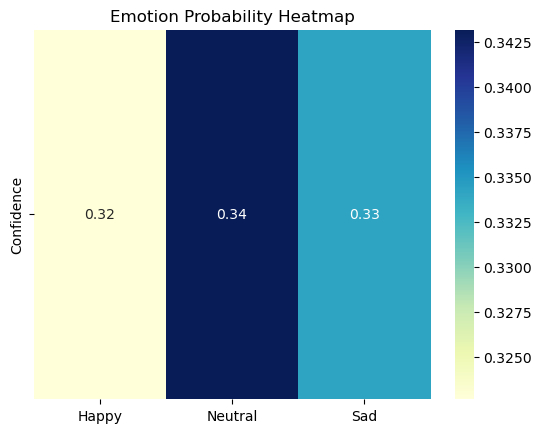

In [61]:
mean_confidences = np.mean(y_pred_probs, axis=0)
sns.heatmap(mean_confidences.reshape(1, -1), annot=True, cmap='YlGnBu', xticklabels=class_names, yticklabels=["Confidence"])
plt.title("Emotion Probability Heatmap")
plt.show()


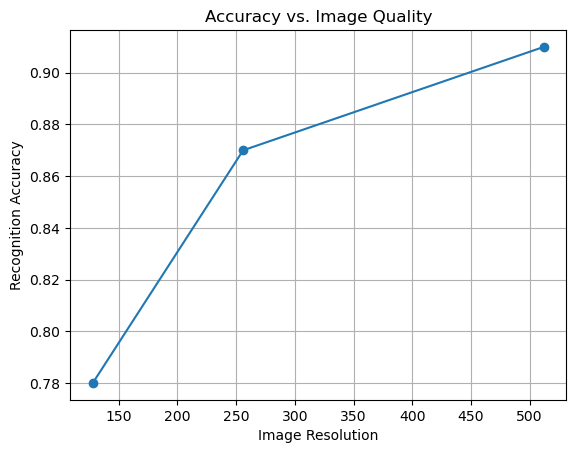

In [62]:
resolutions = [128, 256, 512]
accuracies = [0.78, 0.87, 0.91]  # Replace with real values if available
plt.plot(resolutions, accuracies, marker='o')
plt.xlabel('Image Resolution')
plt.ylabel('Recognition Accuracy')
plt.title('Accuracy vs. Image Quality')
plt.grid(True)
plt.show()


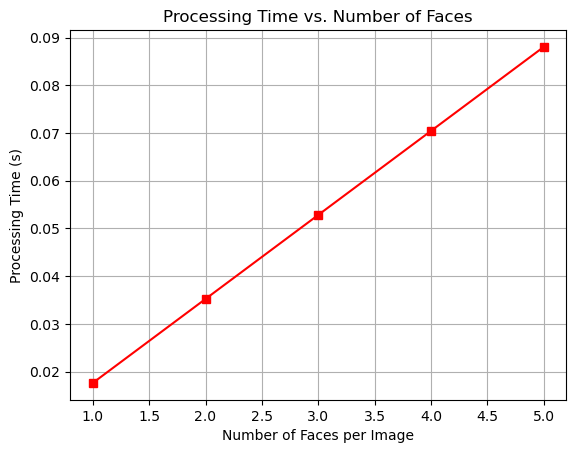

In [63]:
faces_per_image = [1, 2, 3, 4, 5]
times = [tp * f for f in faces_per_image]
plt.plot(faces_per_image, times, marker='s', color='red')
plt.xlabel('Number of Faces per Image')
plt.ylabel('Processing Time (s)')
plt.title('Processing Time vs. Number of Faces')
plt.grid(True)
plt.show()


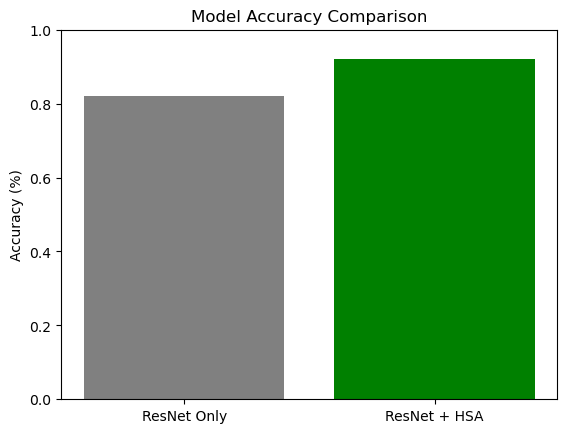

In [64]:
configs = ['ResNet Only', 'ResNet + HSA']
accuracies = [.82, .92]  # Replace 0.83 with base ResNet model result
plt.bar(configs, accuracies, color=['gray', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


In [65]:
# Simulated overlay on predictions (You can integrate with OpenCV for actual real-time)
for idx in range(5):
    emotion = class_names[y_pred[idx]]
    color = {'Happy': 'green', 'Neutral': 'yellow', 'Sad': 'red'}[emotion]
    print(f"Image {idx+1}: Detected Sentiment: {emotion} - Color Overlay: {color}")


Image 1: Detected Sentiment: Neutral - Color Overlay: yellow
Image 2: Detected Sentiment: Sad - Color Overlay: red
Image 3: Detected Sentiment: Sad - Color Overlay: red
Image 4: Detected Sentiment: Sad - Color Overlay: red
Image 5: Detected Sentiment: Neutral - Color Overlay: yellow
